import pandas as pd

In [1]:
import pandas as pd

In [2]:
meteo_2003_2024 = pd.read_csv("meteo_2003_2024.csv")
meteo_2003_2024.head()

,Data,precipitacao_mm,radiacao_media,temp_media,temp_max,temp_min,temp_orvalho_media,humidade_media,vento_rajada_max,vento_vel_media
0,2003-01-01,5.4,1123.000000,21.091667,26.0,18.8,18.250000,84.500000,10.1,2.395833
1,2003-01-02,0.6,1652.214286,22.233333,27.2,18.9,18.033333,78.583333,10.9,2.741667
2,2003-01-03,8.4,1365.285714,21.658333,26.6,18.3,18.266667,81.708333,11.6,3.562500
3,2003-01-04,25.4,1423.785714,21.350000,26.8,17.5,17.716667,81.250000,13.9,4.216667
4,2003-01-05,0.8,1469.846154,21.879167,27.1,17.4,17.162500,75.875000,10.8,4.137500


In [3]:
meteo_2003_2024.shape

(8036, 10)

In [4]:
burn_area_2003_2024 = pd.read_csv(r"C:\Users\sofia\Documents\Data_Analytics_Ironhack\Projects\google_brain\Code\focos_2003_2024.csv")
burn_area_2003_2024.head()

,id_bdq,foco_id,lat,lon,data_pas,pais,estado,municipio,bioma,data,hora
0,8699076,546e7062-5abb-11e8-911c-28924ad12c5c,-15.807,-47.474,2003-02-10 16:53:00,Brasil,DISTRITO FEDERAL,BRASÍLIA,Cerrado,2003-02-10,16:53:00
1,10039136,5e8b5f03-5abb-11e8-911c-28924ad12c5c,-15.896,-48.017,2003-05-17 16:53:00,Brasil,DISTRITO FEDERAL,BRASÍLIA,Cerrado,2003-05-17,16:53:00
2,10266418,23ad605e-5abb-11e8-911c-28924ad12c5c,-15.989,-47.769,2003-06-02 16:53:00,Brasil,DISTRITO FEDERAL,BRASÍLIA,Cerrado,2003-06-02,16:53:00
3,10266417,23ad605d-5abb-11e8-911c-28924ad12c5c,-15.824,-48.026,2003-06-02 16:53:00,Brasil,DISTRITO FEDERAL,BRASÍLIA,Cerrado,2003-06-02,16:53:00
4,10317857,5ee086ae-5abb-11e8-911c-28924ad12c5c,-15.654,-48.216,2003-06-07 17:11:00,Brasil,DISTRITO FEDERAL,BRASÍLIA,Cerrado,2003-06-07,17:11:00


(5052, 11)

In [6]:
import pandas as pd

# === 1) Garantir que as datas estão no formato certo ===
burn_area_2003_2024["data"] = pd.to_datetime(burn_area_2003_2024["data"], errors="coerce").dt.normalize()
meteo_2003_2024["Data"] = pd.to_datetime(meteo_2003_2024["Data"], errors="coerce").dt.normalize()

# === 2) Filtrar pelas coordenadas de Brasília ===
lat0, lon0 = -15.7939, -47.8828
dlat, dlon = 0.5, 0.5
mask_bb = (
    burn_area_2003_2024["lat"].between(lat0 - dlat, lat0 + dlat)
    & burn_area_2003_2024["lon"].between(lon0 - dlon, lon0 + dlon)
)
focos_bb = burn_area_2003_2024[mask_bb].copy()

# === 3) Agregar por dia ===
focos_dia = (
    focos_bb.groupby("data")
            .size()
            .reset_index(name="n_focos")
            .sort_values("data")
)

# Garantir intervalo completo de 2003-01-01 a 2024-12-31
inicio = pd.to_datetime("2003-01-01")
fim = pd.to_datetime("2024-12-31")
idx = pd.date_range(inicio, fim, freq="D")

focos_dia = (
    focos_dia.set_index("data")
             .reindex(idx)
             .fillna({"n_focos": 0})
             .rename_axis("data")
             .reset_index()
)

focos_dia["n_focos"] = focos_dia["n_focos"].astype(int)
focos_dia["target"] = (focos_dia["n_focos"] > 0).astype(int)

# === 4) Merge com meteorologia diária ===
df_final_2003_2024 = focos_dia.merge(
    meteo_2003_2024, 
    left_on="data", 
    right_on="Data", 
    how="left"
).drop(columns=["Data"])

# === 5) Features históricas (sem leakage) ===
df_final_2003_2024 = df_final_2003_2024.sort_values("data").reset_index(drop=True)

df_final_2003_2024["focos_ultimos_3d"] = (
    df_final_2003_2024["n_focos"].rolling(3, min_periods=1).sum().shift(1)
)
df_final_2003_2024["focos_ultimos_7d"] = (
    df_final_2003_2024["n_focos"].rolling(7, min_periods=1).sum().shift(1)
)

if "precipitacao_mm" in df_final_2003_2024.columns:
    df_final_2003_2024["chuva_7d"] = (
        df_final_2003_2024["precipitacao_mm"].rolling(7, min_periods=1).sum().shift(1)
    )
if "temp_media" in df_final_2003_2024.columns:
    df_final_2003_2024["temp_7d"] = (
        df_final_2003_2024["temp_media"].rolling(7, min_periods=1).mean().shift(1)
    )
if "humidade_media" in df_final_2003_2024.columns:
    df_final_2003_2024["humidade_7d"] = (
        df_final_2003_2024["humidade_media"].rolling(7, min_periods=1).mean().shift(1)
    )

# === 6) Variáveis temporais ===
s = pd.to_datetime(df_final_2003_2024["data"])
df_final_2003_2024["mes"] = s.dt.month
df_final_2003_2024["dia_semana"] = s.dt.weekday

# === 7) Salvar CSV ===
df_final_2003_2024.to_csv("df_brasilia_focos_meteo_2003_2024.csv", index=False)

print(df_final_2003_2024.head(), df_final_2003_2024.shape)


        data  n_focos  target  precipitacao_mm  radiacao_media  temp_media  \
0 2003-01-01        0       0              5.4     1123.000000   21.091667   
1 2003-01-02        0       0              0.6     1652.214286   22.233333   
2 2003-01-03        0       0              8.4     1365.285714   21.658333   
3 2003-01-04        0       0             25.4     1423.785714   21.350000   
4 2003-01-05        0       0              0.8     1469.846154   21.879167   

   temp_max  temp_min  temp_orvalho_media  humidade_media  vento_rajada_max  \
0      26.0      18.8           18.250000       84.500000              10.1   
1      27.2      18.9           18.033333       78.583333              10.9   
2      26.6      18.3           18.266667       81.708333              11.6   
3      26.8      17.5           17.716667       81.250000              13.9   
4      27.1      17.4           17.162500       75.875000              10.8   

   vento_vel_media  focos_ultimos_3d  focos_ultimos_7d  

In [7]:
df_final_2003_2024.tail()

,data,n_focos,target,precipitacao_mm,radiacao_media,temp_media,temp_max,temp_min,temp_orvalho_media,humidade_media,vento_rajada_max,vento_vel_media,focos_ultimos_3d,focos_ultimos_7d,chuva_7d,temp_7d,humidade_7d,mes,dia_semana
8031,2024-12-27,0,0,7.8,1551.814286,21.504167,27.3,17.1,18.004167,81.791667,8.2,2.395833,0.0,0.0,79.0,21.327381,85.255952,12,4
8032,2024-12-28,0,0,10.4,1126.785714,22.120833,27.7,18.3,17.483333,77.125000,6.6,1.600000,0.0,0.0,80.8,21.156548,86.172619,12,5
8033,2024-12-29,0,0,19.0,866.421429,20.891667,27.6,17.1,17.245833,81.666667,5.2,1.729167,0.0,0.0,88.0,21.164286,85.339286,12,6
8034,2024-12-30,0,0,2.0,1093.800000,21.108696,26.7,18.0,17.921739,83.434783,12.6,1.969565,0.0,0.0,86.4,21.269643,84.113095,12,0
8035,2024-12-31,0,0,0.0,1233.692857,21.175000,26.7,18.0,17.187500,78.750000,12.1,2.020833,0.0,0.0,81.2,21.221480,83.943064,12,1


In [8]:
# === Teste rápido para validar se não está tudo a zero ===
dias_com_foco = (df_final_2003_2024["n_focos"] > 0).sum()
total_dias = df_final_2003_2024.shape[0]
perc_dias_com_foco = dias_com_foco / total_dias * 100

print(f"Dias com pelo menos 1 foco: {dias_com_foco} ({perc_dias_com_foco:.2f}%)")
print(f"Dias sem foco: {total_dias - dias_com_foco}")


Dias com pelo menos 1 foco: 1328 (16.53%)
Dias sem foco: 6708


# **Baseline tests**

## Distance

### KNN Regression

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

baseline_features = ["precipitacao_mm", "radiacao_media", "temp_media", 
                     "temp_max", "temp_min", "humidade_media", "vento_rajada_max", "vento_vel_media"]


target = "target"

In [39]:
df_base = df_final_2003_2024.dropna(subset=baseline_features+["target"])
X_base = df_base[baseline_features]
y_base = df_base["target"]

In [40]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, 
                                                            test_size=0.2, random_state=42)

In [41]:
print("=== BASELINE MODELS ===")

# Logistic Regression
log_reg = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
log_reg.fit(X_train_b, y_train_b)
y_pred_lr = log_reg.predict(X_test_b)
print("\n--- Logistic Regression (baseline) ---")
print(confusion_matrix(y_test_b, y_pred_lr))
print(classification_report(y_test_b, y_pred_lr))

# Decision Tree
tree = DecisionTreeClassifier(class_weight="balanced", random_state=42)
tree.fit(X_train_b, y_train_b)
y_pred_tree = tree.predict(X_test_b)
print("\n--- Decision Tree (baseline) ---")
print(confusion_matrix(y_test_b, y_pred_tree))
print(classification_report(y_test_b, y_pred_tree))

# KNN
knn = KNeighborsClassifier()
knn.fit(X_train_b, y_train_b)
y_pred_knn = knn.predict(X_test_b)
print("\n--- KNN (baseline) ---")
print(confusion_matrix(y_test_b, y_pred_knn))
print(classification_report(y_test_b, y_pred_knn))

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_b, y_train_b)
y_pred_gb = gb.predict(X_test_b)
print("\n--- Gradient Boosting (baseline) ---")
print(confusion_matrix(y_test_b, y_pred_gb))
print(classification_report(y_test_b, y_pred_gb))

=== BASELINE MODELS ===


c:\Users\sofia\anaconda3\envs\Sofia\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



--- Logistic Regression (baseline) ---
[[1095  237]
 [  57  204]]
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      1332
           1       0.46      0.78      0.58       261

    accuracy                           0.82      1593
   macro avg       0.71      0.80      0.73      1593
weighted avg       0.87      0.82      0.83      1593


--- Decision Tree (baseline) ---
[[1196  136]
 [ 154  107]]
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1332
           1       0.44      0.41      0.42       261

    accuracy                           0.82      1593
   macro avg       0.66      0.65      0.66      1593
weighted avg       0.81      0.82      0.82      1593


--- KNN (baseline) ---
[[1240   92]
 [ 165   96]]
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      1332
           1       0.51      0.37      0.43       261

   

# **Feature engineering**

## **Distance**

**KNN Regression**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

In [11]:
features = [
    'precipitacao_mm', 'temp_media', 'humidade_media', 'chuva_7d', 'temp_7d', 'humidade_7d',
    'focos_ultimos_3d', 'focos_ultimos_7d', 'mes', 'dia_semana'
]

X = df_final_2003_2024[features].fillna(0)
y = df_final_2003_2024["n_focos"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# simple model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [13]:
#predicting
y_pred = knn.predict(X_test)

In [14]:
# metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²: {r2:.4f}, RMSE: {rmse:.4f}")

R²: 0.1383, RMSE: 2.0800


**KNN Classifier**

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [16]:
# 1) Features and target
features = [
    'precipitacao_mm', 'temp_media', 'humidade_media',
    'chuva_7d', 'temp_7d', 'humidade_7d',
    'focos_ultimos_3d', 'focos_ultimos_7d',
    'mes', 'dia_semana'
]

X = df_final_2003_2024[features].fillna(0)
y = df_final_2003_2024['target']

In [17]:
# 2) Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [18]:
# 3) KNN Model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [19]:
# 4) Predections
y_pred = knn.predict(X_test)

In [20]:
# 5) Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1233  107]
 [ 152  116]]
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1340
           1       0.52      0.43      0.47       268

    accuracy                           0.84      1608
   macro avg       0.71      0.68      0.69      1608
weighted avg       0.83      0.84      0.83      1608



# **Linear**

**Logistic Regression**

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# === 1) Escolher features e target
features = [
    "precipitacao_mm", "radiacao_media", "temp_media", "temp_max", "temp_min",
    "temp_orvalho_media", "humidade_media", "vento_rajada_max", "vento_vel_media",
    "focos_ultimos_3d", "focos_ultimos_7d", "chuva_7d", "temp_7d", "humidade_7d",
    "mes", "dia_semana"
]
target = "target"

# Remover linhas com NaN nas features
df_ml = df_final_2003_2024.dropna(subset=features + [target]).copy()

X = df_ml[features]
y = df_ml[target]

# === 2) Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 3) Criar e treinar modelo
model = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
model.fit(X_train, y_train)

# === 4) Previsões e avaliação
y_pred = model.predict(X_test)

print("=== Matriz de confusão ===")
print(confusion_matrix(y_test, y_pred))
print("\n=== Relatório de classificação ===")
print(classification_report(y_test, y_pred, digits=3))


=== Matriz de confusão ===
[[1075  255]
 [  36  226]]

=== Relatório de classificação ===
              precision    recall  f1-score   support

           0      0.968     0.808     0.881      1330
           1      0.470     0.863     0.608       262

    accuracy                          0.817      1592
   macro avg      0.719     0.835     0.745      1592
weighted avg      0.886     0.817     0.836      1592



# **Trees**

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier

### **Decision Tree Regression**

*To predict the number of focus (n_focos)*

In [23]:

# Features and target (number of focus)
X = df_final_2003_2024.drop(columns=["data", "n_focos", "target"])
y = df_final_2003_2024["n_focos"]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
tree_reg = DecisionTreeRegressor(random_state=42, max_depth=5)
tree_reg.fit(X_train, y_train)

# Predictions
y_pred = tree_reg.predict(X_test)

# Evaluation
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

MAE: 0.7342514145413862
RMSE: 2.042899570171815
R²: 0.16879177453787464


### **Decision Tree Classifier**


*To predict if there will be fire or no (target)*

In [24]:
X = df_final_2003_2024.drop(columns=["data", "n_focos", "target"])
y = df_final_2003_2024["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree_clf = DecisionTreeClassifier(random_state=42, max_depth=5)
tree_clf.fit(X_train, y_train)

y_pred = tree_clf.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[1236  104]
 [ 137  131]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      1340
           1       0.56      0.49      0.52       268

    accuracy                           0.85      1608
   macro avg       0.73      0.71      0.72      1608
weighted avg       0.84      0.85      0.85      1608



Using the Decision Tree Classifier is the most suitable approach, as the model directly predicts whether a fire will occur or not, rather than estimating the exact number of fire outbreaks. This makes the results more actionable for risk assessment and early warning systems.

# **Boosting models**

### **Classifier**

In [25]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [29]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Features e target
X = df_final_2003_2024.drop(columns=["data", "n_focos", "target"])
y = df_final_2003_2024["target"]

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# === 1) Gradient Boosting (scikit-learn)
hgb_clf = HistGradientBoostingClassifier(random_state=42)
hgb_clf.fit(X_train, y_train)
y_pred_hgb = hgb_clf.predict(X_test)

print("=== Gradient Boosting ===")
print(confusion_matrix(y_test, y_pred_hgb))
print(classification_report(y_test, y_pred_hgb))

# === 2) XGBoost (mais robusto)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

print("=== XGBoost ===")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

=== Gradient Boosting ===
[[1888  125]
 [ 201  197]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2013
           1       0.61      0.49      0.55       398

    accuracy                           0.86      2411
   macro avg       0.76      0.72      0.73      2411
weighted avg       0.86      0.86      0.86      2411

=== XGBoost ===
[[1886  127]
 [ 223  175]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      2013
           1       0.58      0.44      0.50       398

    accuracy                           0.85      2411
   macro avg       0.74      0.69      0.71      2411
weighted avg       0.84      0.85      0.85      2411



c:\Users\sofia\anaconda3\envs\Sofia\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:32:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔥 Model Performance – Boosting Models

***Gradient Boosting:***

Accuracy: 86%

Recall (fires): 49%

Best balance between false alarms and missed fires



***XGBoost:***

Accuracy: 85%

Recall (fires): 44%

Slightly weaker at detecting fire days

✅ Best model: Gradient Boosting – more reliable for early warning, as it captures more fire days even if it raises some false alarms.

# **Balanced data**

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# === Logistic Regression with class_weight ===
log_reg = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
print("=== Logistic Regression (balanced) ===")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# === Decision Tree with class_weight ===
tree_clf = DecisionTreeClassifier(class_weight="balanced", random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print("\n=== Decision Tree (balanced) ===")
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

#  HistGradientBoostingClassifier (accepts class_weight and NaNs)
from sklearn.ensemble import HistGradientBoostingClassifier

gb_clf = HistGradientBoostingClassifier(class_weight="balanced", random_state=42)
gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_test)
print("\n=== Gradient Boosting (balanced) ===")
print(confusion_matrix(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))


c:\Users\sofia\anaconda3\envs\Sofia\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression (balanced) ===
[[1627  386]
 [  69  329]]
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      2013
           1       0.46      0.83      0.59       398

    accuracy                           0.81      2411
   macro avg       0.71      0.82      0.73      2411
weighted avg       0.88      0.81      0.83      2411


=== Decision Tree (balanced) ===
[[1800  213]
 [ 208  190]]
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      2013
           1       0.47      0.48      0.47       398

    accuracy                           0.83      2411
   macro avg       0.68      0.69      0.68      2411
weighted avg       0.83      0.83      0.83      2411


=== Gradient Boosting (balanced) ===
[[1752  261]
 [ 108  290]]
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      2013
           1       0.53      0.73      0.61  

ROC-AUC and PR-AUC

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, auc
)

# ===== BASELINE =====
baseline_features = ["precipitacao_mm","radiacao_media","temp_media",
                     "temp_max","temp_min","humidade_media",
                     "vento_rajada_max","vento_vel_media"]

df_base = df_final_2003_2024.dropna(subset=baseline_features + ["target"]).copy()
X_base = df_base[baseline_features]
y_base = df_base["target"]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42, stratify=y_base
)

log_reg_base = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
log_reg_base.fit(X_train_b, y_train_b)

y_pred_b = log_reg_base.predict(X_test_b)
y_proba_b = log_reg_base.predict_proba(X_test_b)[:, 1]

# métricas baseline
print("\n=== Logistic Regression (BASELINE) ===")
print(confusion_matrix(y_test_b, y_pred_b))
print(classification_report(y_test_b, y_pred_b, digits=3))

roc_auc_b = roc_auc_score(y_test_b, y_proba_b)
prec_b, rec_b, _ = precision_recall_curve(y_test_b, y_proba_b)
pr_auc_b = auc(rec_b, prec_b)
print(f"ROC-AUC (baseline): {roc_auc_b:.3f}")
print(f"PR-AUC  (baseline): {pr_auc_b:.3f}")

# ===== FEATURE ENGINEERING =====
fe_features = baseline_features + ["chuva_7d","temp_7d","humidade_7d",
                                   "focos_ultimos_3d","focos_ultimos_7d"]

df_fe = df_final_2003_2024.dropna(subset=fe_features + ["target"]).copy()
X_fe = df_fe[fe_features]
y_fe = df_fe["target"]

X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe, y_fe, test_size=0.2, random_state=42, stratify=y_fe
)

log_reg_fe = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
log_reg_fe.fit(X_train_fe, y_train_fe)

y_pred_fe = log_reg_fe.predict(X_test_fe)
y_proba_fe = log_reg_fe.predict_proba(X_test_fe)[:, 1]

# métricas FE
print("\n=== Logistic Regression (FEATURE ENGINEERING) ===")
print(confusion_matrix(y_test_fe, y_pred_fe))
print(classification_report(y_test_fe, y_pred_fe, digits=3))

roc_auc_fe = roc_auc_score(y_test_fe, y_proba_fe)
prec_fe, rec_fe, _ = precision_recall_curve(y_test_fe, y_proba_fe)
pr_auc_fe = auc(rec_fe, prec_fe)
print(f"ROC-AUC (FE): {roc_auc_fe:.3f}")
print(f"PR-AUC  (FE): {pr_auc_fe:.3f}")

c:\Users\sofia\anaconda3\envs\Sofia\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Logistic Regression (BASELINE) ===
[[1047  284]
 [  44  218]]
              precision    recall  f1-score   support

           0      0.960     0.787     0.865      1331
           1      0.434     0.832     0.571       262

    accuracy                          0.794      1593
   macro avg      0.697     0.809     0.718      1593
weighted avg      0.873     0.794     0.816      1593

ROC-AUC (baseline): 0.881
PR-AUC  (baseline): 0.553

=== Logistic Regression (FEATURE ENGINEERING) ===
[[1052  278]
 [  37  225]]
              precision    recall  f1-score   support

           0      0.966     0.791     0.870      1330
           1      0.447     0.859     0.588       262

    accuracy                          0.802      1592
   macro avg      0.707     0.825     0.729      1592
weighted avg      0.881     0.802     0.823      1592

ROC-AUC (FE): 0.891
PR-AUC  (FE): 0.591


c:\Users\sofia\anaconda3\envs\Sofia\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


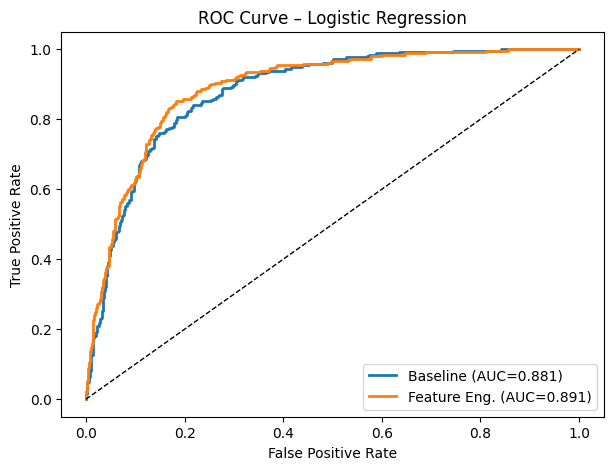

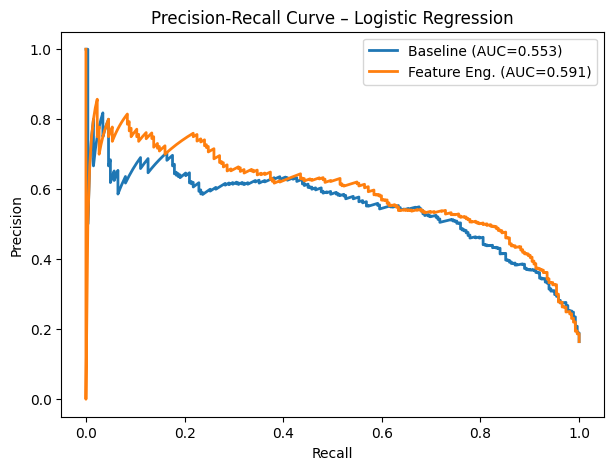

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# === ROC CURVE ===
fpr_b, tpr_b, _ = roc_curve(y_test_b, y_proba_b)
fpr_fe, tpr_fe, _ = roc_curve(y_test_fe, y_proba_fe)

plt.figure(figsize=(7,5))
plt.plot(fpr_b, tpr_b, label=f"Baseline (AUC={roc_auc_b:.3f})", lw=2)
plt.plot(fpr_fe, tpr_fe, label=f"Feature Eng. (AUC={roc_auc_fe:.3f})", lw=2)
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend(loc="lower right")
plt.show()

# === PRECISION-RECALL CURVE ===
prec_b, rec_b, _ = precision_recall_curve(y_test_b, y_proba_b)
prec_fe, rec_fe, _ = precision_recall_curve(y_test_fe, y_proba_fe)

plt.figure(figsize=(7,5))
plt.plot(rec_b, prec_b, label=f"Baseline (AUC={pr_auc_b:.3f})", lw=2)
plt.plot(rec_fe, prec_fe, label=f"Feature Eng. (AUC={pr_auc_fe:.3f})", lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – Logistic Regression")
plt.legend(loc="upper right")
plt.show()